# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

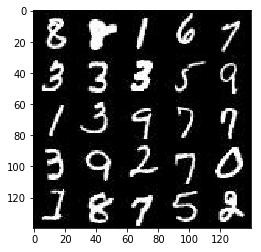

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

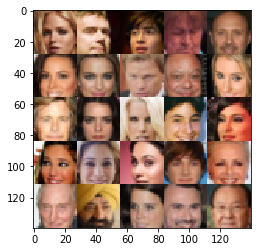

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
    
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
        
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
                
        #print(x1.get_shape())
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_chanel_dim
        
        out = tf.tanh(logits)
        
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [38]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    width = data_shape[1]
    height = data_shape[2]
    out_channel_dim = data_shape[3]
    
    
    real_input, z_input, lr = model_inputs(width, height, out_channel_dim, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every = 100
    print_every = 10
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1                
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                
                
                if steps % show_every == 0:
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)
                    
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({z_input: batch_z, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),                          
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 1.4300
Epoch 1/2... Discriminator Loss: 0.5377... Generator Loss: 3.6670
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 4.6524
Epoch 1/2... Discriminator Loss: 0.8742... Generator Loss: 1.2032
Epoch 1/2... Discriminator Loss: 0.6837... Generator Loss: 2.3253
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 2.6347
Epoch 1/2... Discriminator Loss: 1.6839... Generator Loss: 0.4057
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 2.1017
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 1.2428


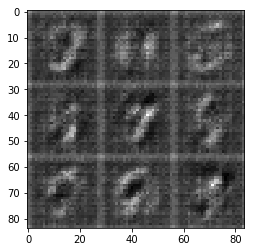

Epoch 1/2... Discriminator Loss: 0.7341... Generator Loss: 1.7285
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.0080
Epoch 1/2... Discriminator Loss: 0.7076... Generator Loss: 1.7936
Epoch 1/2... Discriminator Loss: 0.7558... Generator Loss: 1.5186
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 2.9130
Epoch 1/2... Discriminator Loss: 0.6863... Generator Loss: 1.6533
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 2.1594
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 3.5713
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.8561


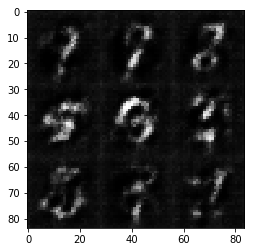

Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 2.0875
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 0.7699... Generator Loss: 1.1598
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 0.6269... Generator Loss: 1.9209
Epoch 1/2... Discriminator Loss: 0.6052... Generator Loss: 1.9426
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 1.1510
Epoch 1/2... Discriminator Loss: 0.6167... Generator Loss: 1.7690
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 2.7669
Epoch 1/2... Discriminator Loss: 0.6200... Generator Loss: 1.7218


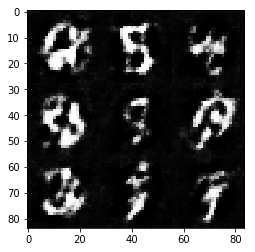

Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 0.6719... Generator Loss: 2.9995
Epoch 1/2... Discriminator Loss: 0.5997... Generator Loss: 1.8096
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.3582
Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 1.5667
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 1.8165
Epoch 1/2... Discriminator Loss: 0.5590... Generator Loss: 1.9324
Epoch 1/2... Discriminator Loss: 0.5236... Generator Loss: 2.1525
Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 0.9795
Epoch 1/2... Discriminator Loss: 0.5595... Generator Loss: 2.7273


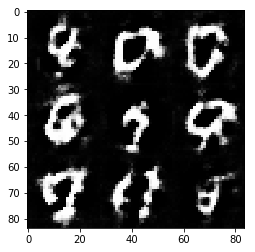

Epoch 1/2... Discriminator Loss: 0.7128... Generator Loss: 1.4229
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 2.1924
Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 2.2434
Epoch 1/2... Discriminator Loss: 0.5429... Generator Loss: 2.1785
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 1.7495
Epoch 1/2... Discriminator Loss: 0.6327... Generator Loss: 1.7288
Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 2.5558
Epoch 1/2... Discriminator Loss: 0.8422... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 2.1812


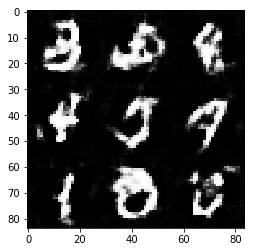

Epoch 1/2... Discriminator Loss: 0.5724... Generator Loss: 1.8582
Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 3.3763
Epoch 1/2... Discriminator Loss: 0.6973... Generator Loss: 1.8971
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 0.9139
Epoch 1/2... Discriminator Loss: 0.5858... Generator Loss: 2.1512
Epoch 1/2... Discriminator Loss: 0.6279... Generator Loss: 2.1337
Epoch 1/2... Discriminator Loss: 0.6972... Generator Loss: 2.0250
Epoch 1/2... Discriminator Loss: 0.6901... Generator Loss: 1.4699
Epoch 1/2... Discriminator Loss: 0.6759... Generator Loss: 1.8303
Epoch 1/2... Discriminator Loss: 0.6647... Generator Loss: 2.3020


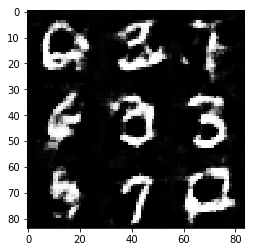

Epoch 1/2... Discriminator Loss: 0.8106... Generator Loss: 1.3158
Epoch 1/2... Discriminator Loss: 0.5622... Generator Loss: 2.2617
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.0088
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 2.8783
Epoch 1/2... Discriminator Loss: 0.7989... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 1.5204
Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 2.9773
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.5975
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 2.9208
Epoch 1/2... Discriminator Loss: 0.5704... Generator Loss: 2.0794


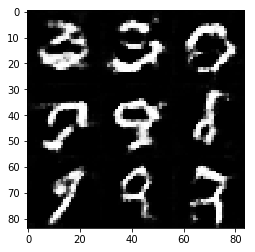

Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 0.6722
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 2.7301
Epoch 1/2... Discriminator Loss: 0.6521... Generator Loss: 2.7712
Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 1.4369
Epoch 1/2... Discriminator Loss: 0.6928... Generator Loss: 1.4060
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 1.3198
Epoch 1/2... Discriminator Loss: 0.7792... Generator Loss: 1.3146
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 1.6101
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 2.0001


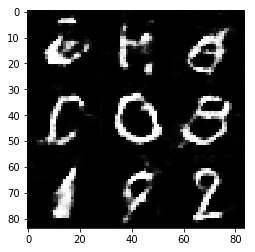

Epoch 1/2... Discriminator Loss: 0.6219... Generator Loss: 1.7361
Epoch 1/2... Discriminator Loss: 0.6860... Generator Loss: 1.4579
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 4.1131
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 1.4487
Epoch 1/2... Discriminator Loss: 0.7065... Generator Loss: 1.8309
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 1.8529
Epoch 1/2... Discriminator Loss: 0.6031... Generator Loss: 1.9610
Epoch 1/2... Discriminator Loss: 0.7171... Generator Loss: 1.3047
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.1508
Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 2.4227


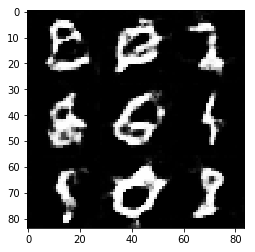

Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.7445
Epoch 1/2... Discriminator Loss: 0.6024... Generator Loss: 1.7861
Epoch 1/2... Discriminator Loss: 0.6586... Generator Loss: 2.0018
Epoch 1/2... Discriminator Loss: 0.7703... Generator Loss: 1.2073
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 1.7145
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 2.1513
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 0.9622
Epoch 2/2... Discriminator Loss: 0.6180... Generator Loss: 2.0779
Epoch 2/2... Discriminator Loss: 1.5310... Generator Loss: 0.4731
Epoch 2/2... Discriminator Loss: 0.7737... Generator Loss: 1.3105


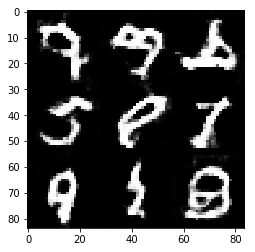

Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 1.9968
Epoch 2/2... Discriminator Loss: 0.5045... Generator Loss: 2.3103
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 1.5412
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 1.1204
Epoch 2/2... Discriminator Loss: 0.7218... Generator Loss: 1.2930
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 2.5334
Epoch 2/2... Discriminator Loss: 0.5710... Generator Loss: 1.8250
Epoch 2/2... Discriminator Loss: 0.6708... Generator Loss: 1.5424
Epoch 2/2... Discriminator Loss: 0.5704... Generator Loss: 1.8262
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 2.0537


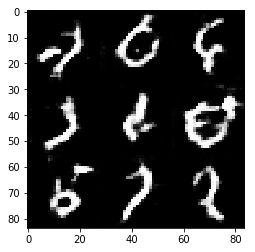

Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 1.6956
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.0959
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.5796
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.0981
Epoch 2/2... Discriminator Loss: 1.2674... Generator Loss: 0.6382
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 0.9397
Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 1.3389
Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 1.4502
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 1.6800
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 2.0041


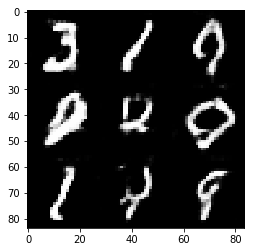

Epoch 2/2... Discriminator Loss: 0.7247... Generator Loss: 1.2684
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.0177
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 2.3381
Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 1.7813
Epoch 2/2... Discriminator Loss: 0.8344... Generator Loss: 1.1173
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 1.8701
Epoch 2/2... Discriminator Loss: 0.5107... Generator Loss: 2.1932
Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 2.4694
Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 1.9106
Epoch 2/2... Discriminator Loss: 0.5668... Generator Loss: 2.0125


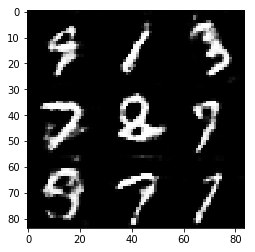

Epoch 2/2... Discriminator Loss: 0.7138... Generator Loss: 1.3164
Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 1.7616
Epoch 2/2... Discriminator Loss: 0.5189... Generator Loss: 2.1148
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.2582
Epoch 2/2... Discriminator Loss: 3.3194... Generator Loss: 0.1184
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.1424
Epoch 2/2... Discriminator Loss: 0.6922... Generator Loss: 1.5217
Epoch 2/2... Discriminator Loss: 0.5947... Generator Loss: 2.0354
Epoch 2/2... Discriminator Loss: 0.6330... Generator Loss: 1.5457
Epoch 2/2... Discriminator Loss: 0.6795... Generator Loss: 1.7958


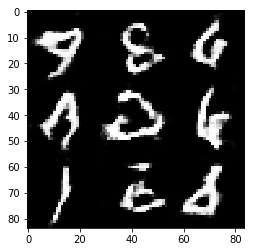

Epoch 2/2... Discriminator Loss: 0.6611... Generator Loss: 1.4433
Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 1.2561
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 1.6494
Epoch 2/2... Discriminator Loss: 0.8467... Generator Loss: 1.0909
Epoch 2/2... Discriminator Loss: 0.8284... Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 0.5085... Generator Loss: 2.1471
Epoch 2/2... Discriminator Loss: 0.5446... Generator Loss: 2.2761
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 1.5272
Epoch 2/2... Discriminator Loss: 0.4943... Generator Loss: 2.5808
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 2.1589


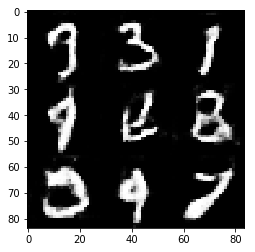

Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.1359
Epoch 2/2... Discriminator Loss: 0.5867... Generator Loss: 1.8127
Epoch 2/2... Discriminator Loss: 0.5855... Generator Loss: 2.2223
Epoch 2/2... Discriminator Loss: 0.6576... Generator Loss: 1.5272
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.0482
Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 1.3572
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.7628
Epoch 2/2... Discriminator Loss: 0.5419... Generator Loss: 2.1057
Epoch 2/2... Discriminator Loss: 0.5696... Generator Loss: 1.9006
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.5146


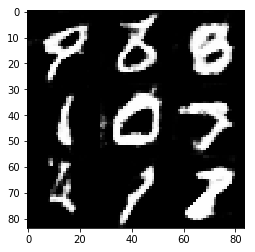

Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 2.3832
Epoch 2/2... Discriminator Loss: 0.5411... Generator Loss: 2.2416
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.2987
Epoch 2/2... Discriminator Loss: 0.6706... Generator Loss: 1.4983
Epoch 2/2... Discriminator Loss: 0.5241... Generator Loss: 2.0892
Epoch 2/2... Discriminator Loss: 0.4723... Generator Loss: 2.5658
Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 3.3050
Epoch 2/2... Discriminator Loss: 0.6449... Generator Loss: 1.9154
Epoch 2/2... Discriminator Loss: 0.5750... Generator Loss: 2.0636
Epoch 2/2... Discriminator Loss: 0.5892... Generator Loss: 1.7724


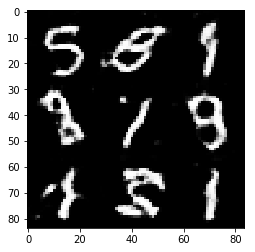

Epoch 2/2... Discriminator Loss: 0.6880... Generator Loss: 1.4067
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.3281
Epoch 2/2... Discriminator Loss: 0.7084... Generator Loss: 1.3757
Epoch 2/2... Discriminator Loss: 0.5554... Generator Loss: 1.8672
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 2.5799
Epoch 2/2... Discriminator Loss: 0.5532... Generator Loss: 1.9783
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 1.0233
Epoch 2/2... Discriminator Loss: 0.5871... Generator Loss: 1.8387
Epoch 2/2... Discriminator Loss: 0.5722... Generator Loss: 1.8093
Epoch 2/2... Discriminator Loss: 0.9638... Generator Loss: 0.8979


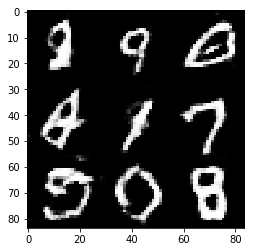

Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 3.3474
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 0.9565
Epoch 2/2... Discriminator Loss: 0.7226... Generator Loss: 1.3791
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.5401
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 1.4681
Epoch 2/2... Discriminator Loss: 0.5711... Generator Loss: 1.8058
Epoch 2/2... Discriminator Loss: 0.7201... Generator Loss: 1.3113
Epoch 2/2... Discriminator Loss: 0.6439... Generator Loss: 1.5567


In [49]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 3.2449... Generator Loss: 13.1898
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 2.3190
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 3.2235
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.6741
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 2.8685
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.5846
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.0123


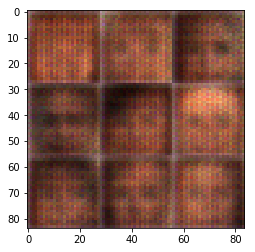

Epoch 1/1... Discriminator Loss: 1.7977... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 2.4532
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 2.5809
Epoch 1/1... Discriminator Loss: 1.8870... Generator Loss: 0.3504
Epoch 1/1... Discriminator Loss: 1.8478... Generator Loss: 0.3017
Epoch 1/1... Discriminator Loss: 2.0183... Generator Loss: 0.2575
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 3.5878
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.8217


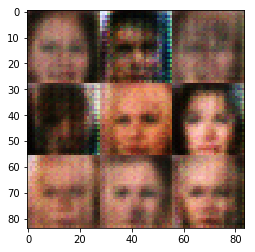

Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.3404
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.6782... Generator Loss: 0.3997
Epoch 1/1... Discriminator Loss: 2.2057... Generator Loss: 0.2047
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 2.1741
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 2.2892
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.5839
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 3.5299
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.4641


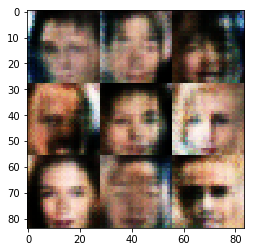

Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 3.5884
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.5380
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.1362


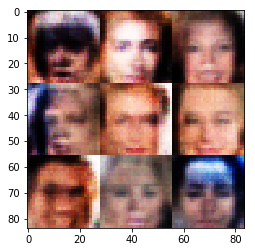

Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 1.4634
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 1.8049
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 5.2597
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.4319
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 1.0656


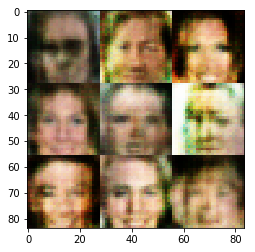

Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.4654
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 1.7136
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 2.5130
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.1027


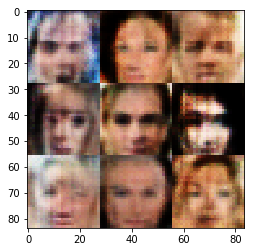

Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.6144
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.9309
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 2.5803
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.7132
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 3.1853
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 3.2505
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.0706


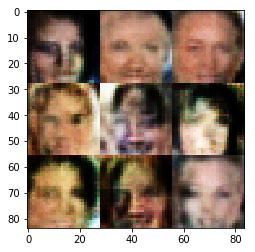

Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 2.5328
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.3747
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 2.1802
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.5002
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 2.9214
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 1.6576


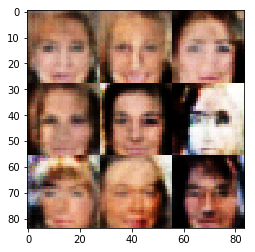

Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.4236
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.4641
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 4.4572
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 3.8071


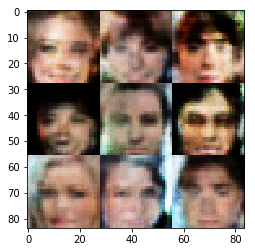

Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 3.2602
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.9645... Generator Loss: 0.2611
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.2988
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 2.4763


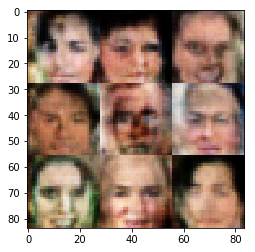

Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 4.1970
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.5462
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.5359
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.9421... Generator Loss: 2.8231


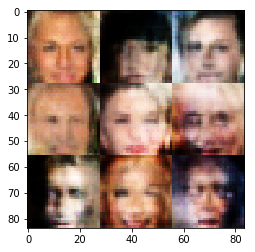

Epoch 1/1... Discriminator Loss: 1.6679... Generator Loss: 4.0470
Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 2.4008
Epoch 1/1... Discriminator Loss: 2.3912... Generator Loss: 2.9202
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 2.0687
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.9528
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.8308


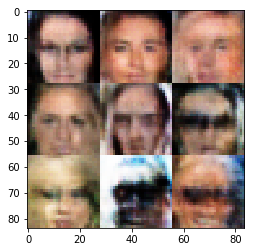

Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.8595
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 2.6920
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 1.7681
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.2848


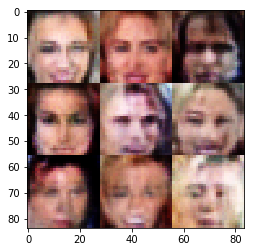

Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 2.0530... Generator Loss: 4.7832
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.8848
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 0.8908


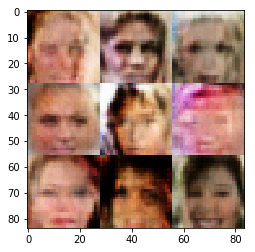

Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 2.3397
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 2.0678
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.5636
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 2.8019
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 3.8049
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.5559
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.0110


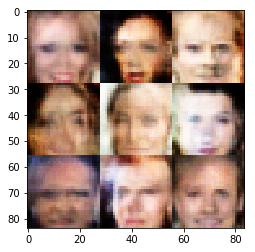

Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 2.6182... Generator Loss: 3.2396
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 1.6788
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 3.2399
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 2.2817
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 1.3046


In [51]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.